In [1]:
import logging

import pickle

import torch
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from torch.distributions import constraints
from torch import nn
import pyro
import pyro.distributions as dist
import pyro.optim as optim
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam
from pyro.infer import Predictive
import seaborn as sns
from pyro import poutine
from sklearn import metrics

In [2]:
pyro.set_rng_seed(10)

In [3]:

with open('data_all.pickle', 'rb') as handle:
    data = pickle.load(handle)
print(data.shape)

nan_mask = np.isnan(data) #when calculating the train/test set to "nan" all the examples that are for testing so that you do not train on them 
print(torch.from_numpy(nan_mask) )

(1127, 5237)
tensor([[False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False],
        ...,
        [False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False]])


In [4]:
class PMF_zero_NB(nn.Module):

    # by default our latent space is 50-dimensional
    # and we use 400 hidden units
    def __init__(self, data,train, dim,alpha):
        super().__init__()
        """Build the Probabilistic Matrix Factorization model using pymc3.



        """
        self.dim = dim   
        self.data = data.copy()
        self.n, self.m = self.data.shape
        self.map = None
        self.bounds = (0,1)
        self.losses = None
        self.predictions = None
        self.returned = None
        self.predictive_svi = None
        self.a=alpha


        # Perform mean value imputation
    
        
        # Low precision reflects uncertainty; prevents overfitting.
        # Set to the mean variance across users and items.
        self.alpha_u = (np.mean(self.data, axis=1).mean())**2 / np.std(self.data, axis=1).mean()
        self.alpha_v = (np.mean(self.data, axis=0).mean())**2 / np.std(self.data, axis=0).mean()
        
        self.beta_u = (np.mean(self.data, axis=1).mean()) / np.std(self.data, axis=1).mean()
        self.beta_v = (np.mean(self.data, axis=0).mean()) / np.std(self.data, axis=0).mean()
        self.bias = self.data.mean()
        self.alpha = 1


    def model(self, train, mask):
        alpha = 1
        beta = 1
   

        drug_plate = pyro.plate("drug_latents", self.n, dim= -1) #independent users
        sideeffect_plate = pyro.plate("sideeffect_latents", self.m, dim= -1) #independent items

        with drug_plate: 
            UA = pyro.sample("UA", dist.Gamma(self.alpha_u, self.beta_u).expand([self.dim]).to_event(1))
            #alpha = pyro.sample("alpha", dist.Poisson(self.alpha))
            #tendacy of people not reporting side effects
            p = pyro.sample("p", dist.Beta(alpha, beta))
        
        with sideeffect_plate:
            VA = pyro.sample("VA", dist.Gamma(self.alpha_v, self.beta_v).expand([self.dim]).to_event(1))
            #possibly add intercepts VA_int = pyro.sample("VA", dist.Normal(0., 1.).to_event(1))
       
        u2_plate = pyro.plate("u2_plate", self.n, dim=-2)

        with sideeffect_plate, u2_plate: 
           # with pyro.poutine.mask(mask=mask):
             Y = pyro.sample("target", dist.ZeroInflatedDistribution( base_dist= dist.NegativeBinomial(self.a, UA@VA.T/( UA@VA.T+self.a)) ,gate = p[:, np.newaxis]), obs=train ) 
             return Y
        

    def guide(self, train=None, mask=None):

        d_alpha = pyro.param('d_alpha', torch.ones(self.n,self.dim), constraint=constraints.positive)#*self.user_mean)
        d_beta = pyro.param('d_beta', 0.5*torch.ones(self.n,self.dim), constraint=constraints.positive)
        rate_alpha = pyro.param('rate_alpha', torch.ones(self.n), constraint=constraints.positive)
        rate_beta = pyro.param('rate_beta', torch.ones(self.n), constraint=constraints.positive)


        s_alpha = pyro.param('s_alpha', torch.ones(self.m,self.dim), constraint=constraints.positive)#*self.item_mean)
        s_beta = pyro.param('s_beta', 0.5*torch.ones(self.m,self.dim), constraint=constraints.positive)
        drug_plate = pyro.plate("drug_latents", self.n, dim= -1) #independent users
        sideeffect_plate = pyro.plate("sideeffect_latents", self.m, dim= -1) #independent items

        with drug_plate: 
            UA = pyro.sample("UA", dist.Gamma(d_alpha, d_beta).to_event(1))
            p = pyro.sample("p", dist.Beta(rate_beta,rate_alpha))

        with sideeffect_plate: 
            VA = pyro.sample("VA", dist.Gamma(s_alpha, s_beta).to_event(1))
    
    def train_SVI(self,train,mask, nsteps=500, lr = 0.05, lrd = 1,verbose=True):
        logging.basicConfig(format='%(message)s', level=logging.INFO)
        svi = SVI(self.model,
        self.guide,
        optim.ClippedAdam({"lr": lr, "lrd": lrd}),
        loss=Trace_ELBO())
        losses = []
        for step in range(nsteps):
            elbo = svi.step(torch.from_numpy(train).float(), mask)
            losses.append(elbo)
            if(verbose):
                if step % 10 == 0:
                    print("Elbo loss: {}".format(elbo))
        self.losses = losses
        #constrained_params = list(pyro.get_param_store().values())
        #PARAMS = [p.unconstrained() for p in constrained_params]
        #print(PARAMS)
        return losses
    
    def sample_predict(self, nsamples=500 , verbose=True):
        unmasked =torch.ones((self.n,self.m), dtype=torch.bool)
        predictive_svi = Predictive(self.model, guide=self.guide, num_samples=nsamples)(None , unmasked)
        if (verbose):
            for k, v in predictive_svi.items():
                print(f"{k}: {tuple(v.shape)}")
        table = predictive_svi["target"].numpy()
        self.predictive_svi = predictive_svi
        self.returned = table
        mc_table = table.mean(axis = 0)
        mc_table_std = table.std(axis = 0)

        self.predictions = mc_table

    
    def predictive_score(self,test,masked):
        exp=50
        # total = test.shape[0]*test.shape[1]
        
        UA =  self.predictive_svi["UA"]
        VA = self.predictive_svi["VA"]
        VA = VA.mean(axis=0).reshape(self.m,self.dim)
        UA = UA.mean(axis=0).reshape(self.n,self.dim)
        p = self.predictive_svi["p"].mean(axis=0).reshape(self.n)
        print(UA.shape)
        score = dist.ZeroInflatedDistribution( base_dist= dist.NegativeBinomial(self.a, UA@VA.T/( UA@VA.T+self.a)) ,gate = p[:, np.newaxis]).log_prob(torch.from_numpy(test))
        mean_score = (score*masked).reshape(-1).logsumexp(-1) -np.log(test.shape[0]*test.shape[1])
        return mean_score
        
    
  
    def rmse(self,test,masked,h):
        low, high = self.bounds
        test_data = test.copy()
        test_data[test_data < h] = low
        test_data[test_data >= h] = high
        size = masked.sum()
        predictions = self.predictions
        predictions[predictions < h] = low
        predictions[predictions >= h] = high
        sqerror = abs(test_data[masked] - predictions[masked]) ** 2  # squared error array
        mse = sqerror.sum()/size
        print("PMF  RMSE: " , np.sqrt(mse))
        fpr, tpr, thresholds = metrics.roc_curve(test_data[masked].astype(int).flatten(),  predictions[masked].astype(int).flatten(), pos_label=1)
        metrics.auc(fpr, tpr)
        print("AUC: %.5f" % metrics.auc(fpr, tpr))
        return np.sqrt(mse) , metrics.auc(fpr, tpr)

    def get_predictions(self):
        return (self.returned,self.predictions)

    def get_predictive_svi(self):
         return (self.predictive_svi)

    
   
       
    

In [5]:
with open('data_train.pickle', 'rb') as handle:
    data2 = pickle.load(handle)
print(data2.shape)

with open('data_all.pickle', 'rb') as handle:
    data = pickle.load(handle)

def predictive_score_for_diim_estimation(data_all, train, classname):
    score=[]
    for d in [1,5,10,20,50,75,100,200,250]:
        nan_mask = np.isnan(train) #when calculating the train/test set to "nan" all the examples that are for testing so that you do not train on them 
        test = classname(data_all,train, d,50)  
        pyro.clear_param_store()
        test.train_SVI(data_all , ~torch.from_numpy(nan_mask), verbose = False)
        test.sample_predict(250)
        score.append(test.predictive_score(data_all,  torch.from_numpy(nan_mask)))
    return score

s = predictive_score_for_diim_estimation(data,data2, PMF_zero_NB)

(1127, 5237)
UA: (250, 1, 1127, 1)
p: (250, 1, 1127)
VA: (250, 1, 5237, 1)
target: (250, 1127, 5237)
torch.Size([1127, 1])
UA: (250, 1, 1127, 5)
p: (250, 1, 1127)
VA: (250, 1, 5237, 5)
target: (250, 1127, 5237)
torch.Size([1127, 5])
UA: (250, 1, 1127, 10)
p: (250, 1, 1127)
VA: (250, 1, 5237, 10)
target: (250, 1127, 5237)
torch.Size([1127, 10])
UA: (250, 1, 1127, 20)
p: (250, 1, 1127)
VA: (250, 1, 5237, 20)
target: (250, 1127, 5237)
torch.Size([1127, 20])
UA: (250, 1, 1127, 50)
p: (250, 1, 1127)
VA: (250, 1, 5237, 50)
target: (250, 1127, 5237)
torch.Size([1127, 50])
UA: (250, 1, 1127, 75)
p: (250, 1, 1127)
VA: (250, 1, 5237, 75)
target: (250, 1127, 5237)
torch.Size([1127, 75])
UA: (250, 1, 1127, 100)
p: (250, 1, 1127)
VA: (250, 1, 5237, 100)
target: (250, 1127, 5237)
torch.Size([1127, 100])
UA: (250, 1, 1127, 200)
p: (250, 1, 1127)
VA: (250, 1, 5237, 200)
target: (250, 1127, 5237)
torch.Size([1127, 200])
UA: (250, 1, 1127, 250)
p: (250, 1, 1127)
VA: (250, 1, 5237, 250)
target: (250, 112

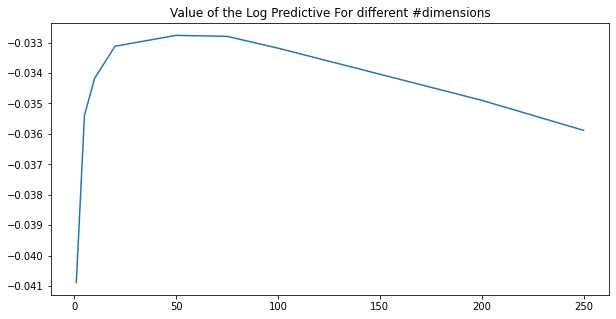

In [6]:
d = [1,5,10,20,50,75,100,200,250]
plt.figure(figsize=(10, 5))
plt.plot(d, s)
plt.title("Value of the Log Predictive For different #dimensions")
plt.savefig("predictive_score_zero_inflNB.png")
plt.show()
pyro.clear_param_store()

In [7]:
pyro.clear_param_store()

nan_mask = np.isnan(data2) #when calculating the train/test set to "nan" all the examples that are for testing so that you do not train on them 
print(torch.from_numpy(nan_mask) )
test = PMF_zero_NB(data,data2,50,50)
loss = test.train_SVI(data, ~torch.from_numpy(nan_mask))


tensor([[False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False,  True, False],
        ...,
        [False, False, False,  ..., False, False, False],
        [False,  True, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False]])
Elbo loss: 82184659.703125
Elbo loss: 29713658.917907715
Elbo loss: 18263230.930847168
Elbo loss: 14853281.876159668
Elbo loss: 14033856.257873535
Elbo loss: 13632448.011413574
Elbo loss: 13175168.023376465
Elbo loss: 12781695.089294434
Elbo loss: 12131878.164672852
Elbo loss: 11595052.633148193
Elbo loss: 11231456.679077148
Elbo loss: 10948230.805908203
Elbo loss: 10748027.88470459
Elbo loss: 10534225.417053223
Elbo loss: 10400449.235992432
Elbo loss: 10319905.045715332
Elbo loss: 10260916.260726929
Elbo loss: 10149407.469573975
Elbo loss: 10010753.000305176
Elbo loss: 9880084.19732666
Elbo loss: 9948560.400787354
Elbo loss: 9828

In [11]:
lloss = test.train_SVI(data, ~torch.from_numpy(nan_mask))


Elbo loss: 9637172.62876892
Elbo loss: 9799880.5703125
Elbo loss: 9651075.595779419
Elbo loss: 9545732.23550415
Elbo loss: 9482618.322677612
Elbo loss: 9500818.18133545
Elbo loss: 9440425.204544067
Elbo loss: 9400076.91481018
Elbo loss: 9326633.296401978
Elbo loss: 9353206.171218872
Elbo loss: 9365301.00366211
Elbo loss: 9300240.48550415
Elbo loss: 9262527.99382019
Elbo loss: 9156941.90838623
Elbo loss: 9271638.401290894
Elbo loss: 9203192.78251648
Elbo loss: 9191983.495819092
Elbo loss: 9104956.537963867
Elbo loss: 9178171.53930664
Elbo loss: 9191572.424865723
Elbo loss: 9142914.511230469
Elbo loss: 9075429.376861572
Elbo loss: 9138386.63406372
Elbo loss: 9176970.029449463
Elbo loss: 9172059.692138672


In [12]:
total_loss = loss +lloss
test.sample_predict(300)

UA: (300, 1, 1127, 50)
p: (300, 1, 1127)
VA: (300, 1, 5237, 50)
target: (300, 1127, 5237)


In [9]:
nan_mask = np.isnan(data2)
#test rmse
test.rmse(data, nan_mask,1)
#train rmse
test.rmse(data, ~nan_mask,1)

PMF  RMSE:  0.36970541053854217
AUC: 0.81738
PMF  RMSE:  0.36927099699806987
AUC: 0.81791


(0.36927099699806987, 0.8179061535277357)

In [10]:
#test rmse
test.rmse(data, nan_mask,4)
#train rmse
test.rmse(data, ~nan_mask,4)

PMF  RMSE:  0.2935781208202841
AUC: 0.50000
PMF  RMSE:  0.29386885556227027
AUC: 0.50000


(0.29386885556227027, 0.5)

In [13]:
Simple_PMF ={}
Simple_PMF['losses'] = loss + lloss
Simple_PMF['predictive_score'] = d
Simple_PMF['train_rmse'] = 0.3692
Simple_PMF['test_rmse'] = 0.3697
Simple_PMF['AUC'] = 0.817
Simple_PMF['train_rmse_3'] = 0.2938
Simple_PMF['test_rmse_3'] = 0.2936
Simple_PMF['predictions'] = test.get_predictions()

In [14]:
with open('SVI_zero_inflated_negative_binomial.pickle', 'wb') as handle:
    pickle.dump(Simple_PMF, handle, protocol=pickle.HIGHEST_PROTOCOL)